In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Даннеы взяты с https://www.kaggle.com/c/unimelb.

In [3]:
df = pd.read_csv('data2.csv')
df.shape

(6000, 39)

In [4]:
X = df.drop('Grant.Status', 1) #исключаем целевую перемнную из обучающей выборки
y = df['Grant.Status'] #целевой переменной присваиваем столбец с биннарным признаком
# 1 - грант выдан, 0 - грант не выдан

Так как требуется предсказать бинарный признак, то для предсказания будет использована логистическая регрессия.

Из свойств данной модели следует, что:
- все $X$ должны быть числовыми данными 
- среди $X$ не должно быть пропущенных значений 


# Предобработка данных

In [5]:
df.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [6]:
numeric_colums = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1'] 
#выбор. столбцов с числовыми значениями
categorical_colums = list(set(X.columns.values.tolist()) - set(numeric_colums)) #выбор. столбцов с категориальными значениями

In [7]:
df.dropna().shape #в скольких строках и столбцах имеются пропущенные значения

(213, 39)

Для вещественных признаков:
- заменим на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменим на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- отделим пропущенное значение, как ещё одну категорию 

In [8]:
X_real = X[numeric_colums] #датафрейм только с численными признаками

In [9]:
X_real_zeros = X_real.fillna(0, inplace=False) #заменяем пропущенные значения на '0'

In [10]:
X_real_mean = X_real.fillna(calculate_means(X_real.copy()), inplace=False) #заменяем пропущенные значения на среднее

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [11]:
X_cat = df[categorical_colums].fillna('NA').astype(str)##заменяем пропущенные значения 
#строковым(категориальным) значением 'NA' 

### Векторизация категориальных признаков

In [12]:
encoder = DV(sparse = False) 

In [13]:
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values()) # преобразуем категориальные признаки при помощи бинарного кода

In [14]:
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0) 
#формируем отложенную выборку в размере 30% от общей выборки

In [15]:
df_train_zeros = np.hstack((X_train_real_zeros, X_train_cat_oh)) #собираем  численные и категориальные признаки в обучающую выборку
df_train_mean = np.hstack((X_train_real_mean, X_train_cat_oh)) #собираем  численные и категориальные признаки в обучающую выборку

In [16]:
X_test_zeros = np.hstack((X_test_real_zeros, X_test_cat_oh))
X_test_mean = np.hstack((X_test_real_mean, X_test_cat_oh))

### Scaling - масштабирование вещественных признаков

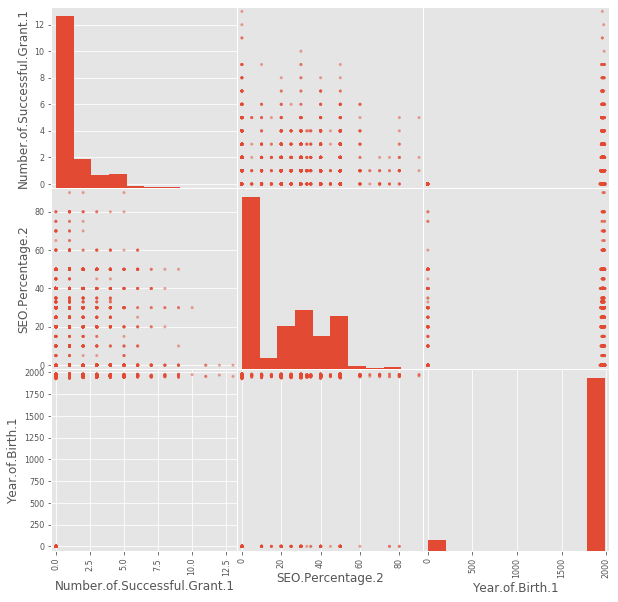

In [17]:
data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_colums)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [18]:
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled =  scaler.transform(X_test_real_zeros)

X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

### Balanced - балансировка классов

In [19]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


In [20]:
indices_to_add = np.random.randint(np.sum(y_train==1), size=np.sum(y_train==0) - np.sum(y_train==1))
X_train_to_add = X_train_scaled[y_train.as_matrix()==1,:][indices_to_add,:]
y_train_to_add = np.repeat(1, np.sum(y_train==0) - np.sum(y_train==1)).T

X_train_added = np.vstack((X_train_scaled, X_train_to_add))
y_train_added = np.hstack([y_train, y_train_to_add])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [21]:
print(X_train_to_add.shape)
print(X_train_added.shape)
print(y_train_added.shape)

(432, 5606)
(4632, 5606)
(4632,)


### Logistic Regression

In [22]:
regressor = LogisticRegression(solver='liblinear')
regressor.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Pipeline

In [23]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('regression', regressor)])

In [24]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('regression', LogisticRegression(solver='liblinear'))])

In [25]:
roc_auc_score(y_test, pipeline.predict(X_test_scaled))

0.8056941091454444

### GridSearch - подбор параметров

In [26]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'regression', 'regression__C', 'regression__class_weight', 'regression__dual', 'regression__fit_intercept', 'regression__intercept_scaling', 'regression__l1_ratio', 'regression__max_iter', 'regression__multi_class', 'regression__n_jobs', 'regression__penalty', 'regression__random_state', 'regression__solver', 'regression__tol', 'regression__verbose', 'regression__warm_start'])

In [27]:
parameters_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

In [28]:
grid_cv = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), param_grid = parameters_grid , scoring= "roc_auc", cv = cv)

In [29]:
%%time
grid_cv.fit(X_train_scaled, y_train)

CPU times: user 8.06 s, sys: 495 ms, total: 8.56 s
Wall time: 4.95 s


GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [30]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(grid_cv.best_estimator_)

0.8719569211137145
{'C': 0.1}
LogisticRegression(C=0.1, solver='liblinear')


### Оценка по отложенному тесту

In [31]:
roc_auc_score(y_test, grid_cv.best_estimator_.predict(X_test_scaled))

0.8072847772260382

### Stratify - cтратификация выборки

In [32]:
from sklearn.model_selection import train_test_split

(x_train_real, x_test_real, 
 y_train_real, y_test_real) = train_test_split(X_real_zeros, y, 
                                               test_size=0.3, 
                                               stratify=y, 
                                               random_state=0)

(x_train_cat, x_test_cat) = train_test_split(X_cat_oh, 
                                             test_size=0.3,
                                             stratify=y,
                                             random_state=0)

In [33]:
x_train_real_scaled = StandardScaler.fit_transform(scaler, x_train_real)
x_test_real_scaled = StandardScaler.fit_transform(scaler, x_test_real)

In [34]:
x_train_scaled = np.hstack((x_train_real_scaled, x_train_cat))
x_test_scaled = np.hstack((x_test_real_scaled, x_test_cat))

In [35]:
optimizer_b = GridSearchCV(LogisticRegression(solver='liblinear',class_weight='balanced'), parameters_grid, scoring="roc_auc", cv=cv)
optimizer_b.fit(x_train_scaled, y_train_real)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [36]:
predict_b = optimizer_b.predict_proba(x_test_scaled)

In [37]:
roc_auc_score(y_test_real, predict_b[:, 1])

0.8794071768692251

### PolynomialFeatures - трансформация вещественных признаков

In [38]:
from sklearn.preprocessing import PolynomialFeatures

transform = PolynomialFeatures(2)
x_train_real_poly = transform.fit_transform(x_train_real)
x_test_real_poly = transform.fit_transform(x_test_real)

print(x_train_real_poly)

[[  1. 100.   0. ...   0.   0.   1.]
 [  1.  60.  40. ...   9.   3.   1.]
 [  1.  50.  50. ...   1.   1.   1.]
 ...
 [  1. 100.   0. ...   0.   0.  49.]
 [  1.  50.  50. ...   4.   2.   1.]
 [  1.  50.  50. ...   9.  33. 121.]]


In [39]:
x_train_poly_scaled = StandardScaler.fit_transform(scaler, x_train_real_poly)
x_test_poly_scaled = StandardScaler.fit_transform(scaler, x_test_real_poly)

In [40]:
x_train_stack = np.hstack((x_train_poly_scaled, x_train_cat))
x_test_stack = np.hstack((x_test_poly_scaled, x_test_cat))

print(x_train_stack.shape)
print(x_test_stack.shape)

(4200, 5698)
(1800, 5698)


In [41]:
optimizer_poly = GridSearchCV(LogisticRegression(solver='liblinear',class_weight='balanced'), parameters_grid, scoring="roc_auc", cv=cv)
optimizer_poly.fit(x_train_stack, y_train_real)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [42]:
pred = optimizer_poly.predict_proba(x_test_stack)
print(pred)

[[0.96735889 0.03264111]
 [0.72522335 0.27477665]
 [0.92358463 0.07641537]
 ...
 [0.29149402 0.70850598]
 [0.90363232 0.09636768]
 [0.39560973 0.60439027]]


In [43]:
pred_train = optimizer_poly.predict_proba(x_train_stack)

In [44]:
test_scores = roc_auc_score(y_test_real, pred[:, 1])

In [45]:
test_scores

0.8875809164141528

In [46]:
train_scores = roc_auc_score(y_train_real, pred_train[:, 1])

In [47]:
train_scores 

0.932618027025712

## Lasso

In [48]:
optimizer_lasso = GridSearchCV(LogisticRegression(class_weight='balanced',
                                                  penalty='l1', 
                                                  solver='liblinear'), 
                               parameters_grid, scoring="roc_auc", cv=cv)

optimizer_lasso.fit(x_train_scaled, y_train_real)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             scoring='roc_auc')

In [49]:
predict_lasso = optimizer_lasso.predict_proba(x_test_scaled)

In [50]:
auc_weight = roc_auc_score(y_test_real, predict_lasso[:, 1])
print(auc_weight)

0.880721990854766


**Лучший результат roc_auc показывает 0.887  
Отбор признаков не дало лучшего резуьтата**